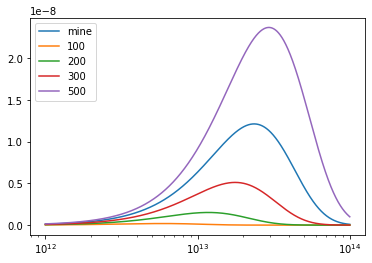

In [113]:
import numpy as np
from matplotlib import pyplot as plt
from sympy import symbols, lambdify
from sympy.functions.elementary.exponential import exp
import astropy.constants as const
from astropy import units as u
from astropy.modeling.blackbody import blackbody_nu
%matplotlib inline


#T, v = symbols('T v')
#blackbody = (2*h.value/c.value**2) * v**3 / (exp(h.value*v/(k_B.value*T)) - 1)

#B = lambdify((T, v), blackbody, modules='numpy')
def sed(nu_obs, z, beta=1.75, gamma=1.7, alpha=0.36):
    #Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    #Undoing Redshift: from Observing to Original
    nu_o = nu_obs * (1+z)
    T_obs = 24.4
    T = T_obs * (1+z)**alpha
    
    bb = (2*const.h.cgs.value/const.c.cgs.value**2) * (nu)**3 / (np.exp((nu/T) * (const.h.cgs.value/const.k_B.cgs.value)) - 1)

nu = np.logspace(12, 14, 2000)
bb = (2*const.h.cgs.value/const.c.cgs.value**2) * (nu)**3 / (np.exp((nu/T) * (const.h.cgs.value/const.k_B.cgs.value)) - 1)
plt.plot(nu, bb, label='mine')
plt.plot(nu, blackbody_nu(nu, 100), label='100')
plt.plot(nu, blackbody_nu(nu, 200), label='200')
plt.plot(nu, blackbody_nu(nu, 300), label='300')
plt.plot(nu, blackbody_nu(nu, 500), label='500')

plt.xscale('log')
plt.legend(loc='upper left');

In [111]:
u.M_sun.to(si)

NameError: name 'si' is not defined